<a href="https://colab.research.google.com/github/Shihori/AI/blob/main/molNW_sec6_cnn_230529_12_11_23_ipynb_CPP_12_22_23_corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/molNW/
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/molNW
cell_images/         model_finetuning.pt  molNW_sec6_cnn_230529_12_11_23_ipynb_copy.ipynb
coronapathogenesis/  model.pt


In [ ]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=86d05b12886d4faf59fb988e55d8a5397547b40055de290d5a1faf4b5670863a
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
import scipy
import random
from tqdm import tqdm
import glob

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms as transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [ ]:
path = "/content/drive/MyDrive/molNW"
im_fd = "/coronapathogenesis/"

/content/drive/MyDrive/molNW/coronapathogenesis/inactivated/120.jpg


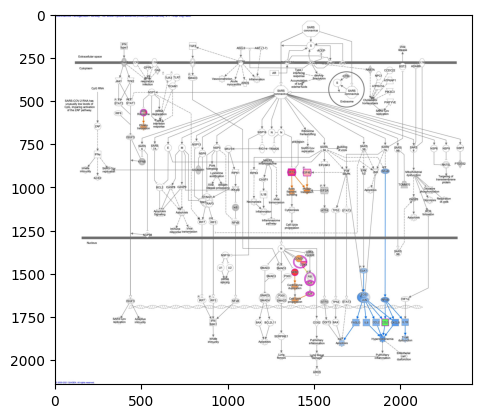

In [ ]:
folder = ['inactivated','activated']
file0 = glob.glob(path + im_fd + folder[0] +"/*.jpg")[0]
print(file0)
image = Image.open(file0)
plt.imshow(image)

In [ ]:
np.array(image)

array([[[251, 255, 220],
        [247, 255, 230],
        [246, 251, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[252, 255, 230],
        [248, 255, 237],
        [249, 252, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 250],
        [251, 251, 249],
        [255, 253, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 247, 255],
        [255, 253, 255],
        [255, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 251, 255],
        [255, 249, 255],
        [251, 249, 250],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 252, 255],
        [253, 248, 254],
        [251, 247, 248],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.
print(f"Using {device} device")

Using cuda device


In [ ]:
image_size = 128;

In [ ]:
SEED = 42

def seed_fix(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_fix(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [ ]:
folder = ['inactivated','activated']
X = [];
y = [];
usenumber = 50
for i,folname in enumerate(folder):
    files1 = glob.glob(path + im_fd + folname +"/*.jpg");
    f_number = len(files1)
    files1, files2=torch.utils.data.random_split(files1,[usenumber,f_number - usenumber])
    for j, file in enumerate(tqdm(files1)):
        outcome = i
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data);
        y.append(outcome)

100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


In [ ]:

X = np.array(X).astype(np.float32).transpose(0,3,1,2)/255
y = np.array(y)

In [ ]:
Nall = X.shape[0]

In [ ]:
tensor_X = torch.tensor(X, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.int64)

In [ ]:
dataset = torch.utils.data.TensorDataset(tensor_X,tensor_y)
n_train = int(Nall * 0.7)
n_val = int(Nall * 0.2)
n_test = Nall - n_train - n_val
train_x, val_x, test_x = torch.utils.data.random_split(dataset, [n_train, n_val,n_test])
print("train =",n_train,",validation =",n_val,",Test =",n_test)

train = 70 ,validation = 20 ,Test = 10


In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_x,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_x,  batch_size=1, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3,128,128),output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=[-7.5, 7.5])
    ]
) #Data augumentation

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.005)

def train(train_loader): #Training
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #data augumentation
        #images = transform(images)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def valid(test_loader): #Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc


acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
nepoch = 300

#Fitting
for epoch in range(nepoch):
    loss, acc = train(train_dataloader)
    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6946 acc: 0.4571 val_loss: 0.6945 val_acc: 0.4500
epoch 1, loss: 0.6935 acc: 0.4857 val_loss: 0.6944 val_acc: 0.4500
epoch 2, loss: 0.6923 acc: 0.5429 val_loss: 0.6942 val_acc: 0.4500
epoch 3, loss: 0.6901 acc: 0.5000 val_loss: 0.6940 val_acc: 0.4500
epoch 4, loss: 0.6940 acc: 0.4000 val_loss: 0.6937 val_acc: 0.4500
epoch 5, loss: 0.6912 acc: 0.5286 val_loss: 0.6932 val_acc: 0.4500
epoch 6, loss: 0.6920 acc: 0.5571 val_loss: 0.6927 val_acc: 0.5500
epoch 7, loss: 0.6907 acc: 0.4857 val_loss: 0.6922 val_acc: 0.5500
epoch 8, loss: 0.6923 acc: 0.5000 val_loss: 0.6916 val_acc: 0.5500
epoch 9, loss: 0.6948 acc: 0.5286 val_loss: 0.6911 val_acc: 0.5500
epoch 10, loss: 0.6942 acc: 0.5143 val_loss: 0.6908 val_acc: 0.5500
epoch 11, loss: 0.6876 acc: 0.5143 val_loss: 0.6906 val_acc: 0.5500
epoch 12, loss: 0.7001 acc: 0.5143 val_loss: 0.6905 val_acc: 0.5500
epoch 13, loss: 0.6928 acc: 0.5143 val_loss: 0.6905 val_acc: 0.5500
epoch 14, loss: 0.6890 acc: 0.5143 val_loss: 0.6905 val_ac

In [ ]:

torch.save(model, 'model.pt')

In [ ]:

model = torch.load('model.pt')

正解率： 55.00000000000001 %


Text(0, 0.5, 'acc')

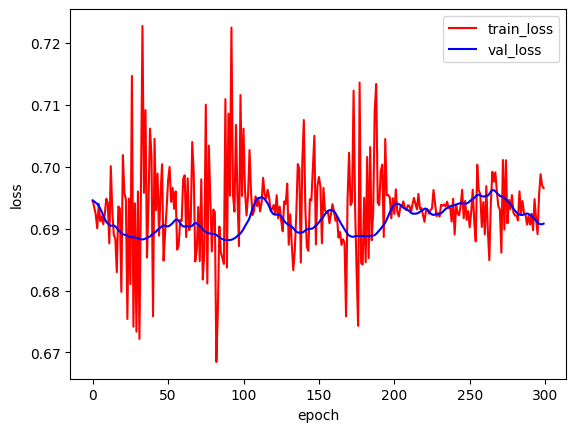

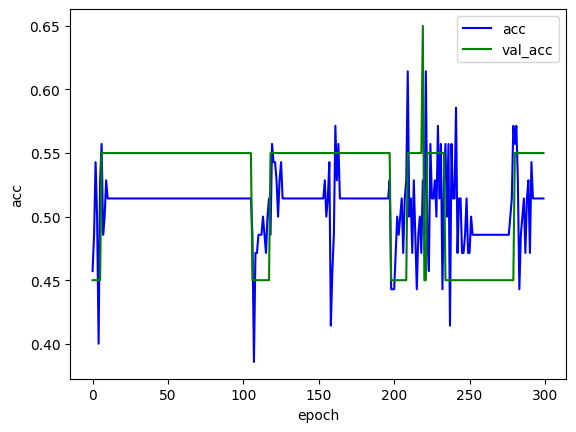

In [ ]:
print('Accuracy：',val_acc_list[-1]*100, '%')


plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

Model Evaluation Test data

In [ ]:
#For Test
def test(test_loader):
    prob = []
    pred = []
    true = []
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            lprob, predicted = outputs.max(1, keepdim=True)
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            prob = np.append(prob, scipy.special.expit(torch.Tensor.numpy(outputs[:,1].to('cpu'))))
            pred = np.append(pred, torch.Tensor.numpy(predicted.to('cpu')))
            true = np.append(true, torch.Tensor.numpy(labels.to('cpu')))
    return prob, pred, true

prob, pred, true,  = test(test_dataloader)


IndexError: ignored

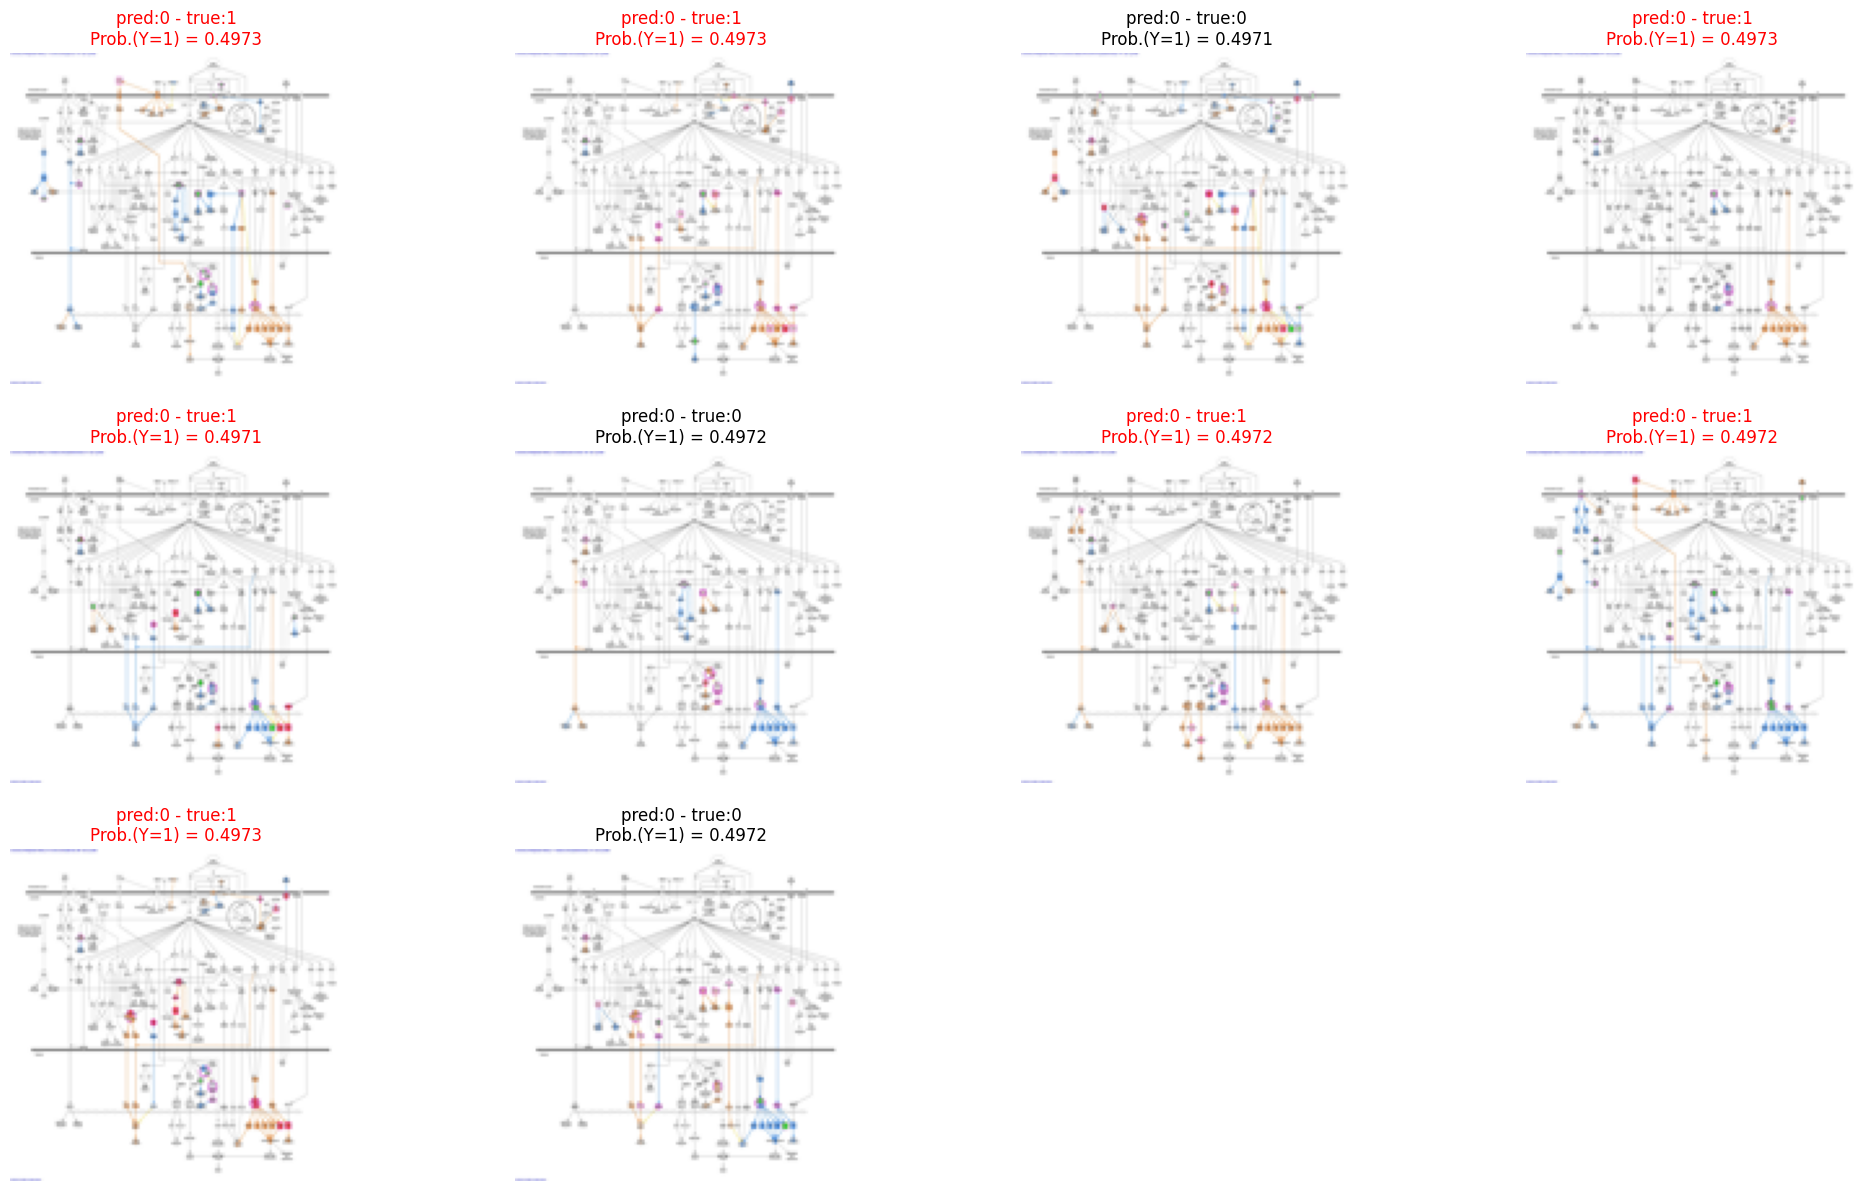

In [ ]:

plt.figure(figsize = (25, 25))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.axis("off")
    if pred[i] == true[i]:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]))
    else:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]), color = "red")

    tmp = test_x[i][0].to('cpu').detach().numpy().copy()
    tmp = tmp.transpose(1, 2, 0)
    img_pil = Image.fromarray((tmp*255).astype(np.uint8))
    plt.imshow(img_pil)




In [ ]:

cmat = confusion_matrix(true, pred)
print(cmat)


tn, fp, fn, tp = cmat.flatten()

acc = round((tp+tn)/(tp+tn+fp+fn),4)
sen = round(tp/(tp+fn),4)
spe = round(tn/(tn+fp),4)
ppv = round(tp/(tp+fp),4)
npv = round(tn/(tn+fn),4)
print("acc=",acc,"sen=",sen," ,spe=",spe," ,ppv=",ppv," ,npv=",npv)



[[3 0]
 [7 0]]
acc= 0.3 sen= 0.0  ,spe= 1.0  ,ppv= nan  ,npv= 0.3


<ipython-input-25-cc60bd63efc6>:11: RuntimeWarning: invalid value encountered in long_scalars
  ppv = round(tp/(tp+fp),4)


Cutoff-value: 0.4972 Sensitivity: 0.7143 Specificity:  1.0


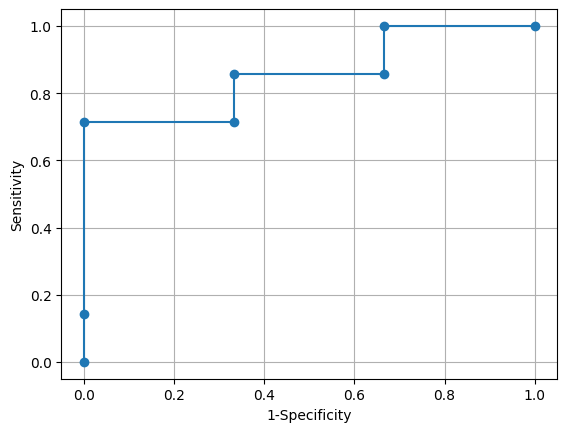

In [ ]:
#ROC curve

fpr, tpr, thresholds = roc_curve(true, prob)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
#plt.savefig(path+'/roc_curve.png')

Youden_index = tpr-fpr
index = np.where(Youden_index==max(Youden_index))[0][0]

cutoff = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]
print("Cutoff-value:",round(cutoff,4),"Sensitivity:",round(sensitivity,4),"Specificity: ",round(specificity,4))




In [ ]:
#!pip install grad-cam -q
#!conda install grad-cam

Grad-CAM

In [ ]:
# Grad-CAM

In [ ]:

model = torch.load('model.pt')
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
target_layer = model.conv4[1]

In [ ]:
gradcam = GradCAM(model, target_layer)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


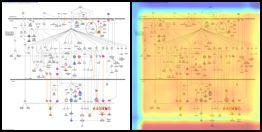

In [ ]:
image_number = 1
torch_img = torch.tensor(np.expand_dims(test_x[image_number][0], 0)).to(device)
images = []
mask, _ = gradcam(torch_img)
heatmap, result = visualize_cam(mask, torch_img)
image0 = torch.squeeze(torch_img,dim=0)
images.extend([image0.cpu(), result])
grid_image = torchvision.utils.make_grid(images, nrow=2)
transforms.ToPILImage()(grid_image)

Finetuning

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [ ]:

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)




def train(train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc




def valid( test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            #break

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc


acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []


In [ ]:
nepoch = 50


for epoch in range(nepoch):

    if(epoch > 0):
        loss, acc = train(train_dataloader)
    else:
        loss, acc = valid(train_dataloader)

    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6961 acc: 0.5143 val_loss: 0.6937 val_acc: 0.5500
epoch 1, loss: 0.6476 acc: 0.4286 val_loss: 0.6937 val_acc: 0.5500
epoch 2, loss: 0.7066 acc: 0.6143 val_loss: 0.6979 val_acc: 0.5000
epoch 3, loss: 0.7029 acc: 0.5000 val_loss: 0.7065 val_acc: 0.4500
epoch 4, loss: 0.7937 acc: 0.6143 val_loss: 0.7200 val_acc: 0.4500
epoch 5, loss: 0.7526 acc: 0.5429 val_loss: 0.7198 val_acc: 0.4500
epoch 6, loss: 0.6492 acc: 0.6143 val_loss: 0.7072 val_acc: 0.4500
epoch 7, loss: 0.7531 acc: 0.4857 val_loss: 0.6682 val_acc: 0.5500
epoch 8, loss: 0.7397 acc: 0.5429 val_loss: 0.6869 val_acc: 0.5500
epoch 9, loss: 0.6777 acc: 0.6000 val_loss: 0.7241 val_acc: 0.4500
epoch 10, loss: 0.6727 acc: 0.5286 val_loss: 1.0007 val_acc: 0.4500
epoch 11, loss: 1.0741 acc: 0.4714 val_loss: 0.7185 val_acc: 0.4500
epoch 12, loss: 0.7873 acc: 0.5571 val_loss: 0.6573 val_acc: 0.6000
epoch 13, loss: 0.6970 acc: 0.4857 val_loss: 0.6399 val_acc: 0.6500
epoch 14, loss: 0.5942 acc: 0.6714 val_loss: 0.6574 val_ac

In [ ]:

torch.save(model, 'model_finetuning.pt')


正解率： 65.0 %


Text(0, 0.5, 'acc')

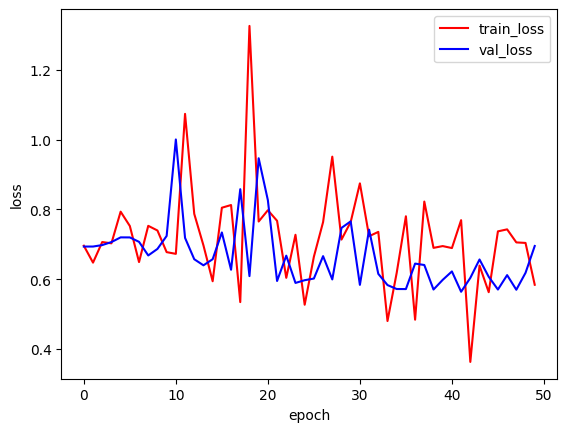

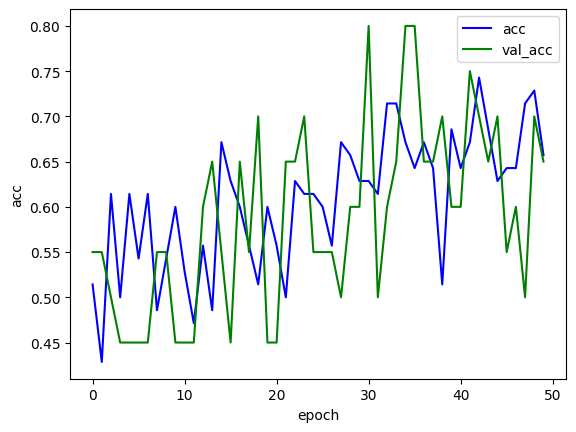

In [ ]:
print('Accuracy：',val_acc_list[-1]*100, '%')

'''Results'''
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')